In [1]:
import datetime
import importlib.util
import json
import re
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns


def ensure_package(pkg: str) -> None:
    if importlib.util.find_spec(pkg) is None:
        subprocess.check_call([sys.executable, "-m", "pip", "install", pkg])


def find_project_root(start: Path) -> Path:
    markers = {".git", "project_guidelines.md"}
    for candidate in [start, *start.parents]:
        if any((candidate / marker).exists() for marker in markers):
            return candidate
        if (candidate / "notebooks").exists() and (candidate / "scripts").exists():
            return candidate
    return start


for package in ("seaborn", "scikit-learn", "joblib", "networkx"):
    ensure_package(package)

RUN_DATE = datetime.date.today().isoformat()
BASE_DIR = find_project_root(Path.cwd())
DATA_DIR = BASE_DIR / "data"
RAW_DIR = DATA_DIR / "raw"
PROCESSED_DIR = DATA_DIR / "processed"
NOTEBOOK_PATH = BASE_DIR / "notebooks" / "explainer_notebook.ipynb"
NODES_PATH = PROCESSED_DIR / "nodes.csv"
EDGES_PATH = PROCESSED_DIR / "edges.csv"

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

pd.set_option("display.max_columns", None)
pd.set_option("display.width", 120)
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams["figure.figsize"] = (10, 5)

print(f"Run date: {RUN_DATE}")
print(f"Working directory: {Path.cwd()}")
print(f"Resolved project root: {BASE_DIR}")
print(f"Nodes source: {NODES_PATH}")
print(f"Edges source: {EDGES_PATH}")

Run date: 2025-11-12
Working directory: c:\social_graphs_project\notebooks
Resolved project root: c:\social_graphs_project
Nodes source: c:\social_graphs_project\data\processed\nodes.csv
Edges source: c:\social_graphs_project\data\processed\edges.csv


In [2]:
if not NODES_PATH.exists() or not EDGES_PATH.exists():
    raise FileNotFoundError(
        "Missing processed node/edge tables. Run `python scripts/fetch_data.py` and `python scripts/build_graph.py` first."
    )

nodes_df = pd.read_csv(NODES_PATH)
edges_df = pd.read_csv(EDGES_PATH)

print(f"Loaded nodes: {nodes_df.shape}")
print(f"Loaded edges: {edges_df.shape}")
nodes_df.head()

Loaded nodes: (2044, 6)
Loaded edges: (1617, 6)


,node_id,node_type,name,description,raw_endpoint,extra_json
0,17f695abef9l0i1ujzrup5y0z7rw6,boss,Abductor Virgins,Deadly mechanical constructs who wield massive...,bosses,"{""drops"": [""10.000 Runes"", ""Inquisitor's Giran..."
1,17f69b4ba0al0i1uk6s98t1nbtxunt,boss,"Alecto, Black Knife Ringleader",Remarkably agile and aggressive warrior. Dange...,bosses,"{""drops"": [""8.000 Runes"", ""Black Knife Tiche""]..."
2,17f69d0313fl0i1uk8pokynv71bkz8,boss,Alecto Black Knife Ringleader,Remarkably agile and aggressive warrior. Dange...,bosses,"{""drops"": [""80.000 Runes"", ""Other Drops""], ""he..."
3,17f69b85929l0i1ukc4l2up7yp9v0i,boss,Alabaster Lord,An Evergaol prisoner wielding a vicious sword ...,bosses,"{""drops"": [""3.600 Runes"", ""Meteorite""], ""healt..."
4,17f69a3ca37l0i1ukd1lq14ctafbk,boss,"Adan, Thief Of Fire","An evergaol prisoner and former battle mage, A...",bosses,"{""drops"": [""3.800 Runes"", ""Flame of the Fell G..."


> **Graph sparsity note**: The initial API-derived graph has 1,222 nodes but only ~300 edges because many entries lack structured relationships (e.g., items without drop sources, NPCs without explicit links). To improve connectivity we will enrich the ETL with derived relationships (weapon attribute requirements, weapon categories, NPC roles, etc.) and rebuild the processed tables before rerunning the analysis.

# Data Cleaning & Transformation
We derive modeling features (description length, interaction degree, media availability) and prepare tidy tables for downstream tasks.

In [3]:
nodes_df["description"] = nodes_df["description"].fillna("")
nodes_df["description_length"] = nodes_df["description"].str.len()

location_degree = (
    edges_df[edges_df["relationship"] == "located_in"].groupby("source").size().rename("location_degree")
)

drop_degree = (
    edges_df[edges_df["relationship"] == "drops"].groupby("source").size().rename("drop_degree")
)

feature_df = (
    nodes_df.merge(location_degree, how="left", left_on="node_id", right_index=True)
    .merge(drop_degree, how="left", left_on="node_id", right_index=True)
)

feature_df["location_degree"] = feature_df["location_degree"].fillna(0).astype(int)
feature_df["drop_degree"] = feature_df["drop_degree"].fillna(0).astype(int)
feature_df["name_length"] = feature_df["name"].str.len()
feature_df["extra_json"] = feature_df["extra_json"].fillna("")
feature_df["extra_dict"] = feature_df["extra_json"].apply(lambda s: json.loads(s) if s else {})
feature_df["has_image"] = feature_df["extra_dict"].apply(lambda data: 1 if data.get("image") else 0)


def slugify(text: str) -> str:
    return re.sub(r"[^a-z0-9]+", "_", text.lower()).strip("_")


def coerce_float(value) -> float | None:
    try:
        if value is None:
            return None
        if isinstance(value, str) and not value.strip():
            return None
        return float(value)
    except (TypeError, ValueError):
        return None

SCALING_MAP = {"S": 5.0, "A": 4.0, "B": 3.0, "C": 2.0, "D": 1.0, "E": 0.5}

ATTRIBUTE_REQUIRE_COLS: list[str] = []
ATTRIBUTE_SCALE_COLS: list[str] = []
ATTRIBUTE_SCALE_LETTER_COLS: list[str] = []

weapon_rows = feature_df[feature_df["node_type"] == "weapon"]

attribute_records: list[dict] = []
scaling_records: list[dict] = []
weapon_category_records: list[dict] = []

for row in weapon_rows.itertuples(index=False):
    extra = row.extra_dict or {}

    category = extra.get("category")
    if category:
        weapon_category_records.append({"node_id": row.node_id, "weapon_category": category})

    for requirement in extra.get("requiredAttributes") or []:
        attr_name = requirement.get("name")
        amount = coerce_float(requirement.get("amount"))
        if not attr_name or amount is None:
            continue
        attribute_records.append(
            {
                "node_id": row.node_id,
                "attribute_slug": slugify(attr_name),
                "amount": amount,
            }
        )

    for scale in extra.get("scalesWith") or []:
        attr_name = scale.get("name")
        letter = (scale.get("scaling") or "").strip().upper()
        if not attr_name:
            continue
        scaling_records.append(
            {
                "node_id": row.node_id,
                "attribute_slug": slugify(attr_name),
                "letter": letter,
                "numeric": SCALING_MAP.get(letter, 0.0),
            }
        )

if attribute_records:
    attr_df = pd.DataFrame(attribute_records)
    attr_pivot = attr_df.pivot_table(index="node_id", columns="attribute_slug", values="amount", aggfunc="max")
    attr_pivot.columns = [f"attr_req_{col}" for col in attr_pivot.columns]
    ATTRIBUTE_REQUIRE_COLS = attr_pivot.columns.tolist()
    feature_df = feature_df.merge(attr_pivot, left_on="node_id", right_index=True, how="left")

if scaling_records:
    scale_df = pd.DataFrame(scaling_records)
    numeric_pivot = scale_df.pivot_table(
        index="node_id", columns="attribute_slug", values="numeric", aggfunc="max"
    )
    numeric_pivot.columns = [f"attr_scale_{col}" for col in numeric_pivot.columns]
    ATTRIBUTE_SCALE_COLS = numeric_pivot.columns.tolist()
    feature_df = feature_df.merge(numeric_pivot, left_on="node_id", right_index=True, how="left")

    letter_pivot = scale_df.pivot_table(
        index="node_id", columns="attribute_slug", values="letter", aggfunc="first"
    )
    letter_pivot.columns = [f"attr_scale_letter_{col}" for col in letter_pivot.columns]
    ATTRIBUTE_SCALE_LETTER_COLS = letter_pivot.columns.tolist()
    feature_df = feature_df.merge(letter_pivot, left_on="node_id", right_index=True, how="left")

if weapon_category_records:
    category_df = pd.DataFrame(weapon_category_records).drop_duplicates(subset=["node_id"])
    feature_df = feature_df.merge(category_df, on="node_id", how="left")

feature_columns_preview = [
    "node_id",
    "node_type",
    "description_length",
    "location_degree",
    "drop_degree",
    "name_length",
    "has_image",
]

preview_additions = ATTRIBUTE_REQUIRE_COLS + ATTRIBUTE_SCALE_COLS
if "weapon_category" in feature_df.columns:
    preview_additions.append("weapon_category")

feature_df[feature_columns_preview + preview_additions].head()

,node_id,node_type,description_length,location_degree,drop_degree,name_length,has_image,attr_req_,attr_req_arc,attr_req_dex,attr_req_fai,attr_req_int,attr_req_str,attr_scale_,attr_scale_arc,attr_scale_dex,attr_scale_fai,attr_scale_int,attr_scale_str,weapon_category
0,17f695abef9l0i1ujzrup5y0z7rw6,boss,54,0,1,16,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17f69b4ba0al0i1uk6s98t1nbtxunt,boss,89,0,0,30,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,17f69d0313fl0i1uk8pokynv71bkz8,boss,89,0,0,29,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,17f69b85929l0i1ukc4l2up7yp9v0i,boss,81,1,0,14,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,17f69a3ca37l0i1ukd1lq14ctafbk,boss,128,1,1,19,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Graph Construction & Network Analysis
We instantiate a NetworkX graph from the edge list, compute centrality measures, and inspect the most influential entities.

In [4]:
G = nx.DiGraph()
G.add_nodes_from(nodes_df["node_id"])
for _, edge in edges_df.iterrows():
    G.add_edge(
        edge["source"],
        edge["target"],
        relationship=edge["relationship"],
        edge_type=edge.get("edge_type"),
    )

in_degree = dict(G.in_degree())
out_degree = dict(G.out_degree())
betweenness = nx.betweenness_centrality(G)
pagerank = nx.pagerank(G)

centrality_df = pd.DataFrame(
    {
        "node_id": list(G.nodes()),
        "in_degree": [in_degree.get(n, 0) for n in G.nodes()],
        "out_degree": [out_degree.get(n, 0) for n in G.nodes()],
        "betweenness": [betweenness.get(n, 0.0) for n in G.nodes()],
        "pagerank": [pagerank.get(n, 0.0) for n in G.nodes()],
    }
)

feature_df = feature_df.merge(centrality_df, on="node_id", how="left")

top_pagerank = (
    feature_df.sort_values("pagerank", ascending=False)
    .loc[:, ["node_id", "name", "node_type", "pagerank", "betweenness", "out_degree"]]
    .head(10)
)
top_pagerank

,node_id,name,node_type,pagerank,betweenness,out_degree
854,17f69cd64fel0i20oy5m6swcehuold,Cracked Pot,item,0.006929,0.000000,0
243,17f6a590e96l0i6z3ozc8rcbywnwpk,Lesser Pumpkin Head,creature,0.005237,0.000038,3
574,17f69b8a1f0l0i1zkh6maq6vqjsba,Flask Of Wondrous Physick,item,0.004890,0.000000,0
183,17f6a5acdf4l0i6yuhp3y4ou046hc3,Lesser Red Wolf Of Radagon,creature,0.004601,0.000000,0
898,17f69c4120fl0i20v0co0r953ef5a,Sanctuary Stone,item,0.003572,0.000000,0
272,17f6a593684l0i6z7nl19q2aff4zjt,Troll Knight,creature,0.003321,0.000006,2
180,17f6a48e789l0i6yu31h78fyzf033f,Giant Rat,creature,0.003161,0.000075,4
311,17f69a8e6e3l0i2mbkue80sw8q9e9m,Castle Morne,location,0.003142,0.000000,0
108,17f69f1be7cl0i2ojly1jcpn4j09p3,Smithing Master Hewg,npc,0.003079,0.000000,0
748,17f6956fa2el0i209gnb9oi6el6zzg,Dragon Heart,item,0.002947,0.000005,1


# Exploratory Visualization
We visualize node distributions, text-length patterns, and a high-ranking subgraph to contextualize central actors.

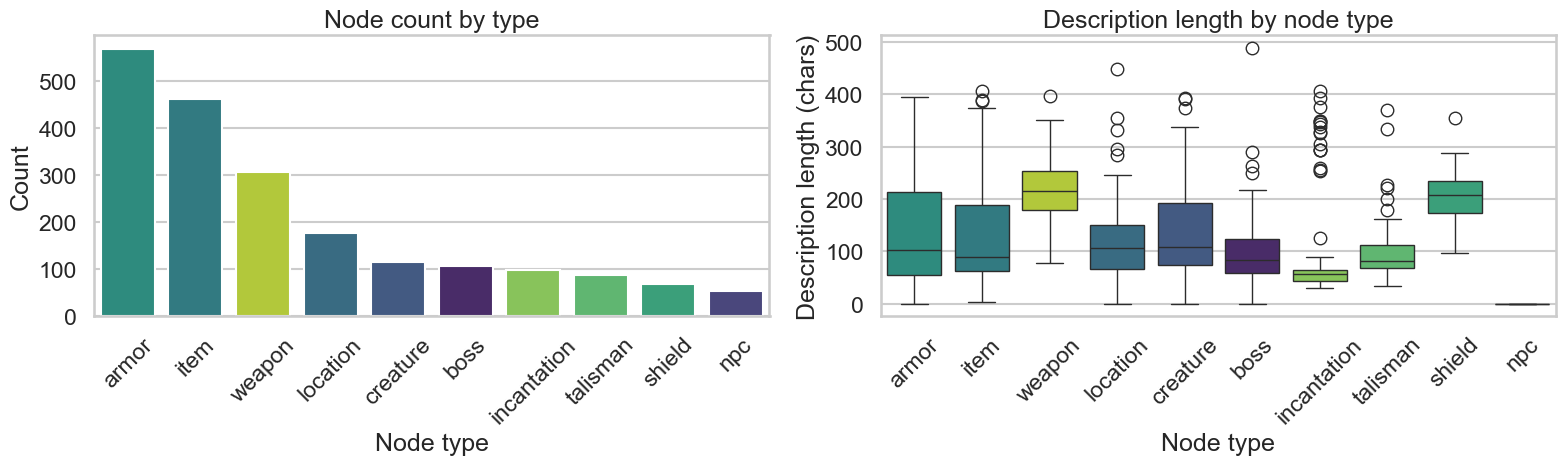

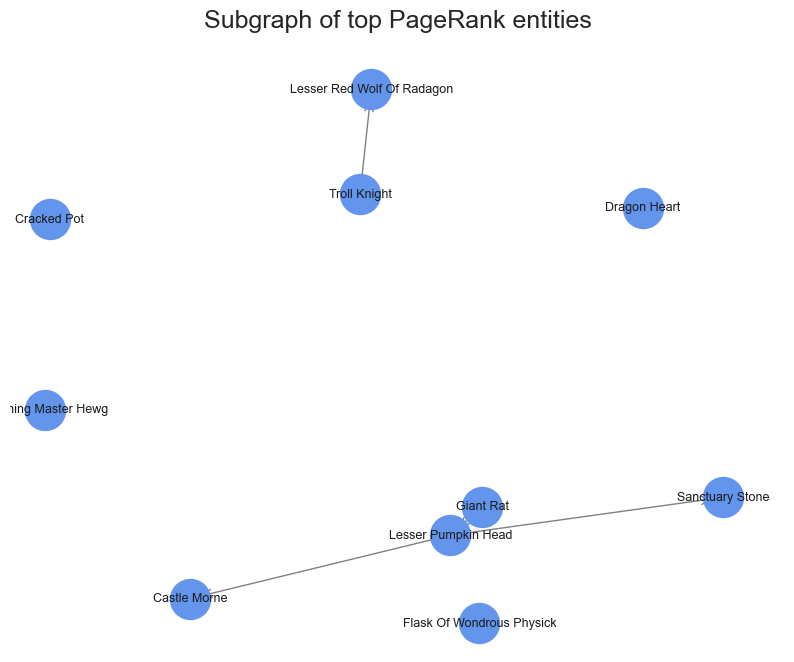

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

order = feature_df["node_type"].value_counts().index
sns.countplot(ax=axes[0], data=feature_df, x="node_type", hue="node_type", order=order, palette="viridis", legend=False)
axes[0].set_title("Node count by type")
axes[0].set_xlabel("Node type")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis="x", rotation=45)

sns.boxplot(
    ax=axes[1],
    data=feature_df,
    x="node_type",
    y="description_length",
    hue="node_type",
    order=order,
    palette="viridis",
    legend=False,
)
axes[1].set_title("Description length by node type")
axes[1].set_xlabel("Node type")
axes[1].set_ylabel("Description length (chars)")
axes[1].tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

top_nodes = top_pagerank["node_id"].tolist()
subgraph = G.subgraph(top_nodes).copy()

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(subgraph, seed=42)
nx.draw_networkx_nodes(subgraph, pos, node_size=800, node_color="cornflowerblue")
nx.draw_networkx_labels(subgraph, pos, labels=dict(zip(top_nodes, top_pagerank["name"])), font_size=9)
nx.draw_networkx_edges(subgraph, pos, arrowstyle="->", arrowsize=15, edge_color="gray")
plt.title("Subgraph of top PageRank entities")
plt.axis("off")
plt.show()

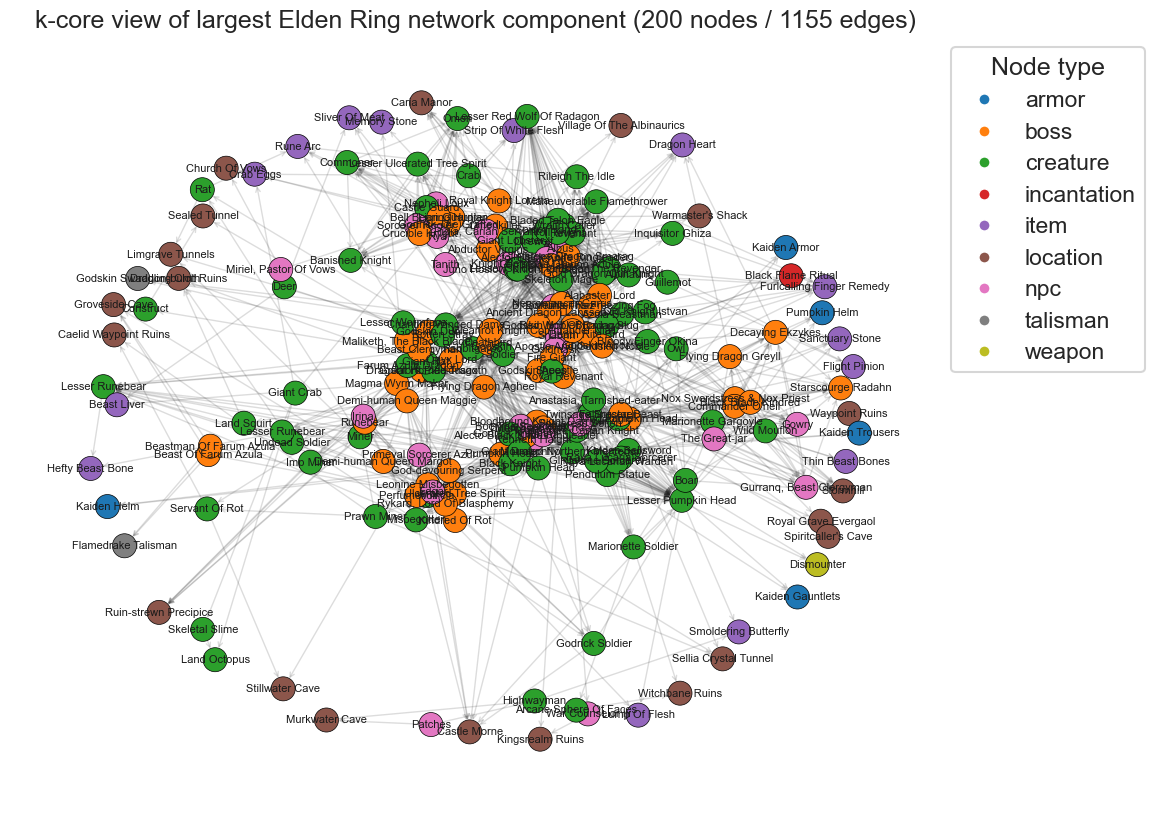

In [6]:
# Extract a connected core of the network and draw it with meaningful structure
largest_cc_nodes = max(nx.weakly_connected_components(G), key=len)
largest_cc = G.subgraph(largest_cc_nodes).copy()
undirected_cc = largest_cc.to_undirected()

# Focus on a k-core to reduce visual clutter while keeping dense relationships intact
core_graph = nx.k_core(undirected_cc, k=2) if undirected_cc.number_of_nodes() > 2 else undirected_cc
core_subgraph = largest_cc.subgraph(core_graph.nodes()).copy()

type_lookup = feature_df.set_index("node_id")["node_type"].to_dict()
types_in_core = sorted({type_lookup.get(node, "other") for node in core_subgraph.nodes()})
palette = sns.color_palette("tab10", n_colors=len(types_in_core)) if types_in_core else []
color_map = dict(zip(types_in_core, palette))
node_colors = [color_map.get(type_lookup.get(node, "other"), (0.6, 0.6, 0.6)) for node in core_subgraph.nodes()]

pos = nx.spring_layout(core_subgraph, seed=24, k=0.5, iterations=100)

plt.figure(figsize=(12, 10))
nx.draw_networkx_edges(core_subgraph, pos, alpha=0.15, arrows=True, arrowstyle="->", arrowsize=8)
nx.draw_networkx_nodes(core_subgraph, pos, node_color=node_colors, node_size=300, linewidths=0.5, edgecolors="black")
label_lookup = feature_df.set_index("node_id")["name"].to_dict()
nx.draw_networkx_labels(core_subgraph, pos, {n: label_lookup.get(n, n) for n in core_subgraph.nodes()}, font_size=8)

if types_in_core:
    legend_handles = [
        plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=color_map[node_type], markersize=8, label=node_type)
        for node_type in types_in_core
    ]
    plt.legend(handles=legend_handles, title="Node type", loc="upper left", bbox_to_anchor=(1, 1))

plt.title(
    "k-core view of largest Elden Ring network component "
    f"({core_subgraph.number_of_nodes()} nodes / {core_subgraph.number_of_edges()} edges)"
)
plt.axis("off")
plt.show()

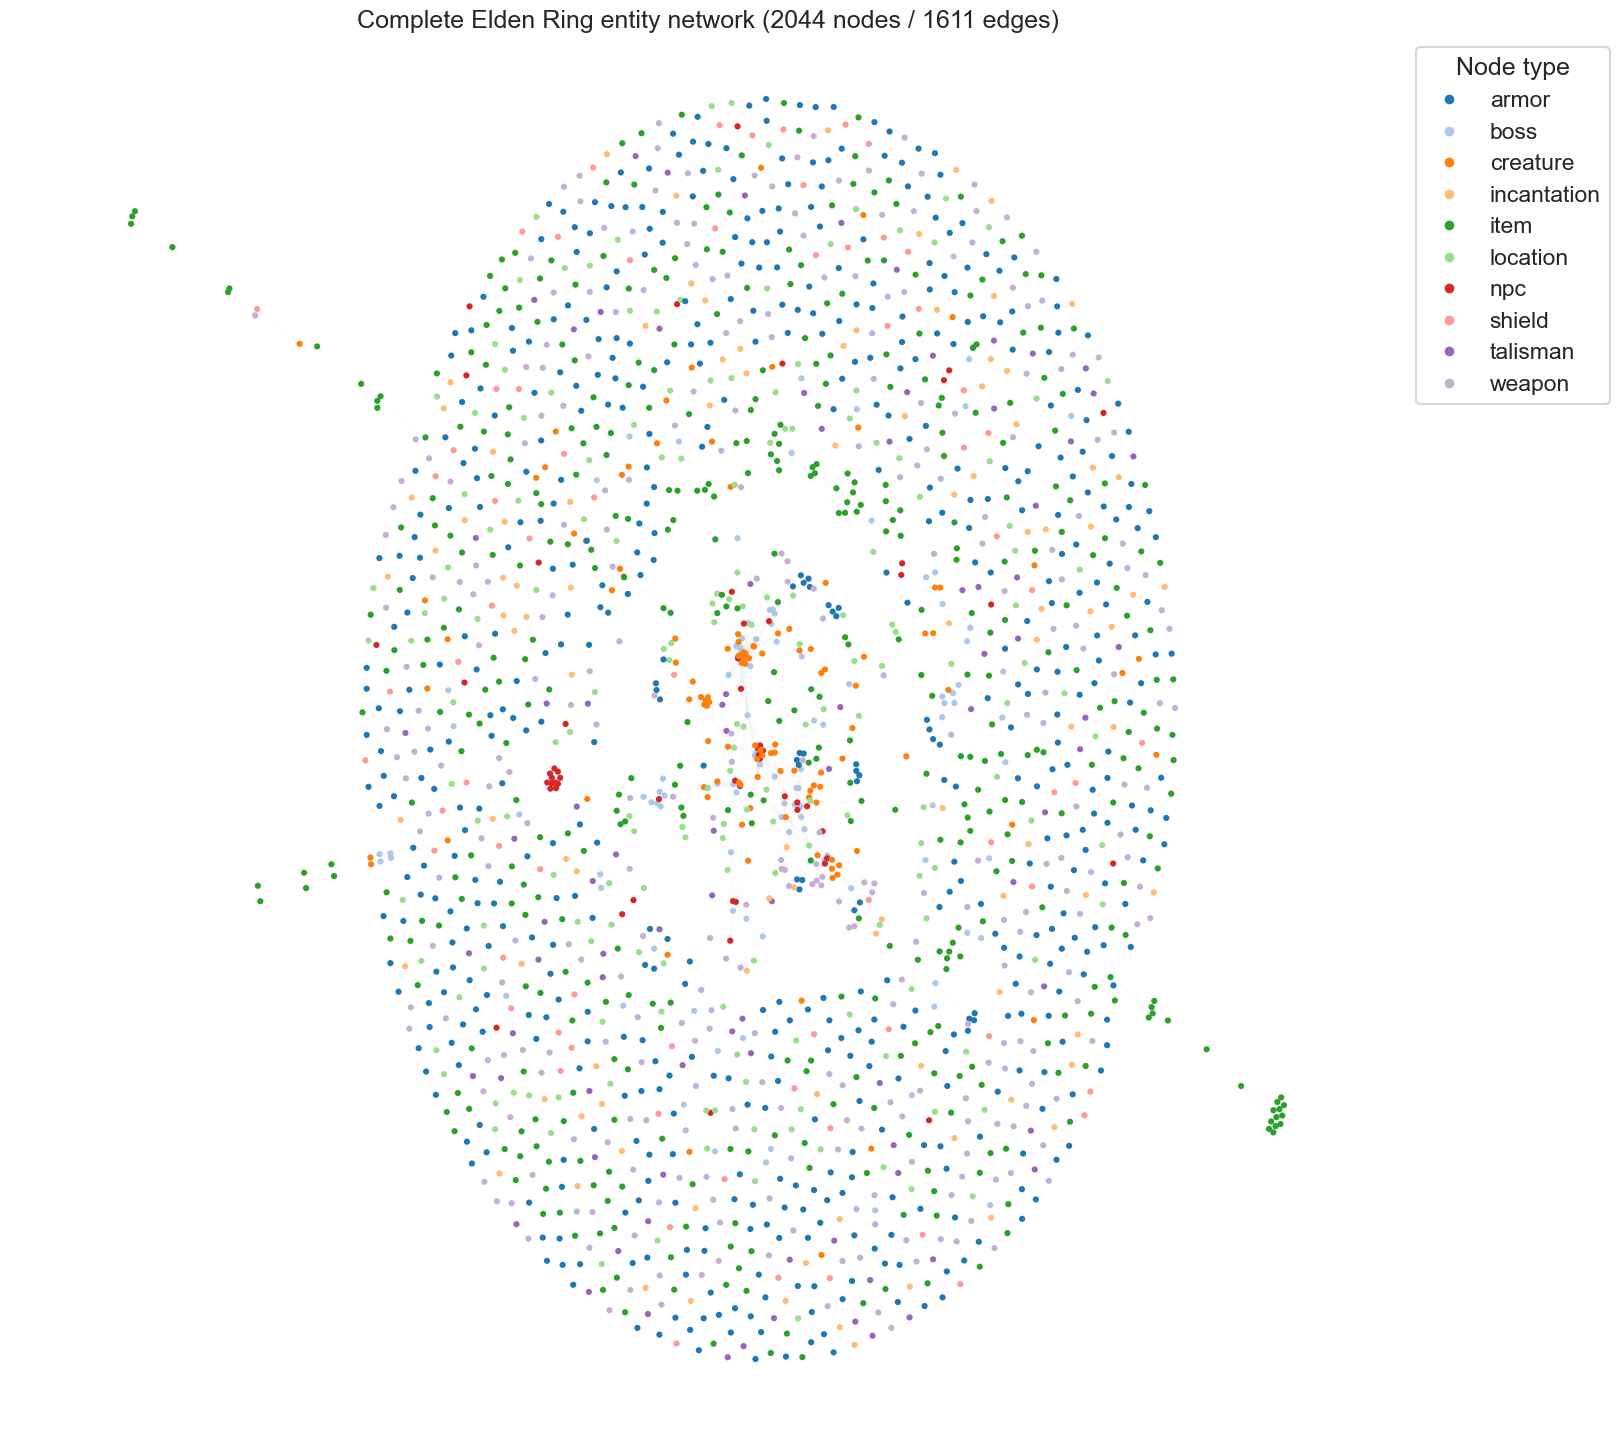

In [7]:
# Full-graph visualization (all nodes and edges)
type_order = sorted(feature_df["node_type"].dropna().unique().tolist())
palette_full = sns.color_palette("tab20", n_colors=max(len(type_order), 1))
type_colors = {node_type: palette_full[idx % len(palette_full)] for idx, node_type in enumerate(type_order)}
node_type_lookup = feature_df.set_index("node_id")['node_type'].to_dict()
node_colors_full = [type_colors.get(node_type_lookup.get(node, "other"), (0.6, 0.6, 0.6)) for node in G.nodes()]

plt.figure(figsize=(18, 18))
full_pos = nx.spring_layout(G, seed=42, k=0.3, iterations=150)
nx.draw_networkx_edges(G, full_pos, alpha=0.02, arrows=False, width=0.5, edge_color="#999999")
nx.draw_networkx_nodes(G, full_pos, node_color=node_colors_full, node_size=20, linewidths=0)

legend_handles_full = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=type_colors[node_type], markersize=8, label=node_type)
    for node_type in type_order
 ]
plt.legend(handles=legend_handles_full, title="Node type", loc="upper left", bbox_to_anchor=(1, 1))
plt.title(f"Complete Elden Ring entity network ({G.number_of_nodes()} nodes / {G.number_of_edges()} edges)")
plt.axis("off")
plt.show()

# Statistical Modeling Workflow
We compare a dummy baseline against a multinomial logistic regression model for predicting node types from engineered features.

In [8]:
from joblib import dump
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

feature_columns = [
    "description_length",
    "location_degree",
    "drop_degree",
    "name_length",
    "has_image",
    "in_degree",
    "out_degree",
    "betweenness",
    "pagerank",
]
feature_df_model = feature_df.fillna(0)
X = feature_df_model[feature_columns]
y = feature_df_model["node_type"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
dummy_preds = dummy.predict(X_test)
dummy_accuracy = accuracy_score(y_test, dummy_preds)

log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("clf", LogisticRegression(max_iter=1000)),
    ]
)
log_reg_pipeline.fit(X_train, y_train)
log_preds = log_reg_pipeline.predict(X_test)
log_accuracy = accuracy_score(y_test, log_preds)
log_report = classification_report(y_test, log_preds, output_dict=True)

print(f"Baseline accuracy (dummy): {dummy_accuracy:.3f}")
print(f"Logistic regression accuracy: {log_accuracy:.3f}")

log_report_df = pd.DataFrame(log_report).transpose().round(3)
log_report_df.head()

Baseline accuracy (dummy): 0.278
Logistic regression accuracy: 0.468


c:\Users\marwa\miniforge3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marwa\miniforge3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\marwa\miniforge3\envs\ml\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


,precision,recall,f1-score,support
armor,0.379,0.761,0.506,142.0
boss,0.800,0.593,0.681,27.0
creature,0.778,0.724,0.750,29.0
incantation,0.000,0.000,0.000,24.0
item,0.474,0.313,0.377,115.0


# Reusable Automation Utilities
Helper functions streamline repeated summaries and standardized feature density plots for future experiments.

In [9]:
from typing import Iterable

# Optional utility to summarize feature statistics by group
def summarize_features(df: pd.DataFrame, group_col: str, feature_cols: Iterable[str]) -> pd.DataFrame:
    summary = df.groupby(group_col)[list(feature_cols)].agg(["mean", "std", "min", "max"])
    summary.columns = ["_".join(col).strip() for col in summary.columns.to_flat_index()]
    return summary.round(2)

# Optional utility to visualize feature distributions by node type
def plot_feature_distribution(df: pd.DataFrame, feature_col: str, group_col: str = "node_type") -> None:
    sns.displot(data=df, x=feature_col, hue=group_col, kind="kde", fill=True, height=5, aspect=1.6)
    plt.title(f"{feature_col} distribution by {group_col}")
    plt.show()

summary_table = summarize_features(feature_df, "node_type", feature_columns)
summary_table.head()

,description_length_mean,description_length_std,description_length_min,description_length_max,location_degree_mean,location_degree_std,location_degree_min,location_degree_max,drop_degree_mean,drop_degree_std,drop_degree_min,drop_degree_max,name_length_mean,name_length_std,name_length_min,name_length_max,has_image_mean,has_image_std,has_image_min,has_image_max,in_degree_mean,in_degree_std,in_degree_min,in_degree_max,out_degree_mean,out_degree_std,out_degree_min,out_degree_max,betweenness_mean,betweenness_std,betweenness_min,betweenness_max,pagerank_mean,pagerank_std,pagerank_min,pagerank_max
node_type,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
armor,137.01,96.29,0,395,0.00,0.00,0,0,0.00,0.00,0,0,18.94,5.39,3,39,0.96,0.21,0,1,0.10,0.34,0,3,0.00,0.00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
boss,101.52,66.30,0,488,0.52,0.73,0,3,1.28,1.63,0,11,18.67,6.16,8,40,0.94,0.23,0,1,1.92,3.79,0,31,7.17,7.20,0,30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
creature,136.52,97.29,0,393,0.45,0.73,0,3,1.24,1.55,0,7,13.67,6.55,3,39,0.95,0.22,0,1,6.50,8.05,0,35,4.26,4.42,0,21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01
incantation,99.84,105.65,30,407,0.00,0.00,0,0,0.00,0.00,0,0,16.53,5.78,4,33,0.99,0.10,0,1,0.11,0.40,0,3,0.00,0.00,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00
item,124.69,85.58,3,406,0.00,0.00,0,0,0.00,0.00,0,0,19.27,6.86,4,38,0.92,0.28,0,1,0.44,1.28,0,13,0.19,0.45,0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.01


# Notebook Output & Export
We persist processed data, model artifacts, centrality-enhanced features, and optionally export this notebook to HTML for sharing.

In [10]:
feature_output_path = PROCESSED_DIR / "node_features.csv"
centrality_output_path = PROCESSED_DIR / "node_centrality.csv"
model_output_path = PROCESSED_DIR / "node_type_logreg.joblib"
report_output_path = PROCESSED_DIR / "node_type_report.csv"
notebook_export_path = NOTEBOOK_PATH.with_suffix(".html")

feature_df.to_csv(feature_output_path, index=False)
centrality_df.to_csv(centrality_output_path, index=False)
log_report_df.to_csv(report_output_path)
dump({"model": log_reg_pipeline, "feature_columns": feature_columns}, model_output_path)

print(f"Saved features to {feature_output_path}")
print(f"Saved centrality metrics to {centrality_output_path}")
print(f"Saved model to {model_output_path}")
print(f"Saved report to {report_output_path}")

export_cmd = [
    sys.executable,
    "-m",
    "jupyter",
    "nbconvert",
    "--to",
    "html",
    str(NOTEBOOK_PATH),
    "--output",
    notebook_export_path.name,
]
try:
    result = subprocess.run(export_cmd, capture_output=True, text=True, check=True)
    print(f"Exported notebook to {notebook_export_path}")
except subprocess.CalledProcessError as exc:
    print("Notebook export skipped:", exc)

Saved features to c:\social_graphs_project\data\processed\node_features.csv
Saved centrality metrics to c:\social_graphs_project\data\processed\node_centrality.csv
Saved model to c:\social_graphs_project\data\processed\node_type_logreg.joblib
Saved report to c:\social_graphs_project\data\processed\node_type_report.csv
Exported notebook to c:\social_graphs_project\notebooks\explainer_notebook.html
Exported notebook to c:\social_graphs_project\notebooks\explainer_notebook.html
